# IMPORTS

In [128]:
import math
import warnings
import numpy  as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import re
from IPython.core.display import HTML
from plotly.subplots import make_subplots

warnings.filterwarnings( 'ignore' )

##  Helper Functions

In [40]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
#    plt.rcParams['font.size'] = 24   
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('max_colwidth',200)
    pd.set_option('display.max_rows',2000)
    pd.set_option('display.max_columns',50)
    pd.set_option('display.float_format',lambda x: '{:,.2f}'.format(x) )   
    
def info(x):

    data = pd.DataFrame({'Columns' : x.columns,
                         'Dtypes' :  x.dtypes,
                         '# observ.': x.shape[0],
                         #"# unique": x.nunique(),
                         '# nulls' : x.isna().sum(),
                         '% nulls' : x.isna().sum()/x.shape[0]*100
                        }).reset_index(drop=True)
    
    return print(data)    

In [37]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [4]:
df_cleaned_aldeia_realestate_raw = pd.read_csv( '../data/cleaned_aldeia_realestate.csv')

# DATA DESCRIPTION

In [5]:
df1=df_cleaned_aldeia_realestate_raw.copy()

## Data Information

In [41]:
info(df1)

           Columns   Dtypes  # observ.  # nulls  % nulls
0         page_seq    int64       1092        0     0.00
1        house_seq    int64       1092        0     0.00
2            title   object       1092        0     0.00
3              url   object       1092        0     0.00
4          address   object       1092        0     0.00
5          area_m2  float64       1092        0     0.00
6         bedrooms  float64       1092        0     0.00
7        en_suites    int64       1092        0     0.00
8            price    int64       1092        0     0.00
9        bathrooms  float64       1092        0     0.00
10  parking_spaces    int64       1092        0     0.00
11            type   object       1092        0     0.00
12     street_name   object       1092      281    25.73
13   street_number  float64       1092      875    80.13
14            city   object       1092        0     0.00
15      condo_name   object       1092        0     0.00


In [7]:
df1.sample(2)

,page_seq,house_seq,title,url,address,area_m2,bedrooms,en_suites,price,bathrooms,parking_spaces,type,street_name,street_number,city,condo_name
468,13,18,Casa com 4 Quartos a Venda 350m2,www.vivareal.com.br/imovel/casa-4-quartos-aldeia-da-serra-bairros-barueri-com-garagem-350m2-venda-RS1800000-id-2478076675/,"Alameda dos Jasmins, 394 - Aldeia da Serra, Santana de Parnaíba - SP",350.00,4.00,4.00,1800000,4.00,4.00,House,Alameda dos Jasmins,394.00,Santana de Parnaíba SP,Morada das Flores
863,1,33,Casa de condominio com 3 Quartos a Venda 400m2,www.vivareal.com.br/imovel/casa-de-condominio-3-quartos-residencial-morada-dos-lagos-bairros-barueri-com-garagem-400m2-venda-RS3800000-id-2476706707/?__vt=plp:b,"Residencial Morada dos Lagos, Barueri - SP",400.00,3.00,3.00,3800000,3.00,3.00,House,NaN,nan,Barueri SP,Morada dos Lagos


## Filter

In [8]:
df1 = df1[ (df1['type'] == 'House') & (df1['condo_name'] != 'Not Aldeia da Serra') & \
          (~ df1['condo_name'].isna()) & (df1['condo_name'] != 'Ingaí') & (df1['condo_name'] != 'Quintas do Ingaí')
         ]

## Fillout NA

In [9]:
df1['en_suites'].fillna(0, inplace = True)
df1['parking_spaces'].fillna(0, inplace = True)

## Change Data Types

In [10]:
int_cols = ['en_suites', 'parking_spaces']
df1[int_cols] = df1[int_cols].astype(int)

# DESCRIPTIVE STATISTICS

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### Numerical Atributes

In [12]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,page_seq,0.00,14.00,14.00,4.42,4.00,3.36,0.76,0.21
1,house_seq,0.00,35.00,35.00,17.33,17.50,10.37,0.01,-1.21
2,area_m2,20.00,"2,200.00","2,180.00",458.03,400.00,237.54,3.16,14.54
3,bedrooms,1.00,10.00,9.00,3.87,4.00,0.81,1.34,7.84
4,en_suites,0.00,8.00,8.00,3.10,3.00,1.27,-0.01,-0.00
5,price,"585,000.00","15,000,000.00","14,415,000.00","2,352,439.41","1,800,000.00","1,605,420.42",3.39,17.67
6,bathrooms,1.00,10.00,9.00,3.87,4.00,0.81,1.34,7.84
7,parking_spaces,0.00,20.00,20.00,4.37,4.00,2.19,1.72,5.32
8,street_number,nan,nan,"6,720.00",728.41,nan,878.19,3.24,18.19


In [20]:
px.histogram(df1, 
             x = 'area_m2' ,
             title = 'House Prices Histogram and Boxplot',
             labels = {'price': 'house price'},
             marginal = 'box'
            )

### Categorical Atributes

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

title           552
url            1092
address         341
type              1
street_name     101
city              2
condo_name        8
dtype: int64

In [15]:
fig = px.box(data_frame=df1,
             x='price',
             y='condo_name',
             labels={ 'price' : 'house price',
                      'condo_name': 'condominium'
                    },
             title='House price boxplot by condominium'
            )
fig.show()

# 2.0.  FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## 2.4. Feature Engineering

In [16]:
df2['price_m2'] = df2['price']/df2['area_m2']

In [24]:
df2['size'] = pd.qcut(df2['area_m2'], 7, labels=['01 Cozy', '02 Small', '03 Medium', '04 Large', '05 Super large', '06 gigantic', '07 Pharaonic'])

In [25]:
df2['size'].value_counts()

06 gigantic       162
02 Small          162
05 Super large    159
01 Cozy           156
04 Large          155
03 Medium         151
07 Pharaonic      147
Name: size, dtype: int64

In [31]:
#df2[df2['size'] == '07 Pharaonic']

## Hipothesis

**1.** Morada dos Lagos, Pássaros e Estrelas have highest prices per square meter (m2).

**2.** Barueri-SP city prices are higher than Santana de Parnaíba-SP.

**3.** Houses with 4 bedrooms have higher prices per m2.

**4.** Houses with suites have higher prices per m2 on average.

**4.** Morada dos Lagos have more large houses.

# FILTERING

In [75]:
df3 = df2.copy()

## Filtragem das Linhas


In [91]:
df3 = df3[ (df3['area_m2']> 100) & (df3['price']> 600000) ]

In [50]:
# Retirar outliers??

# Q1 = df3['price_m2'].quantile(0.25)
# Q3 = df3['price_m2'].quantile(0.75)
# IQR = Q3 - Q1
# df3 = df3[ (df3['price_m2'] >= (Q1 - 1.5 * IQR)) & (df3['price_m2'] <= (Q3 + 1.5 * IQR)) ] 

In [82]:
df3.shape

(1090, 13)

## Selecao das Colunas

In [83]:
df3.drop(['page_seq', 'house_seq', 'title', 'address', 'street_number'], axis =1, inplace=True)

KeyError: "['page_seq' 'house_seq' 'title' 'address' 'street_number'] not found in axis"

# EXPLORATORY DATA ANALYSIS

In [84]:
df4 = df3.copy()

## Analise Univariada

### Response Variable

In [92]:
px.histogram( df4['price'] )

In [95]:
px.histogram( df4['price_m2'] )

### Numerical Variable

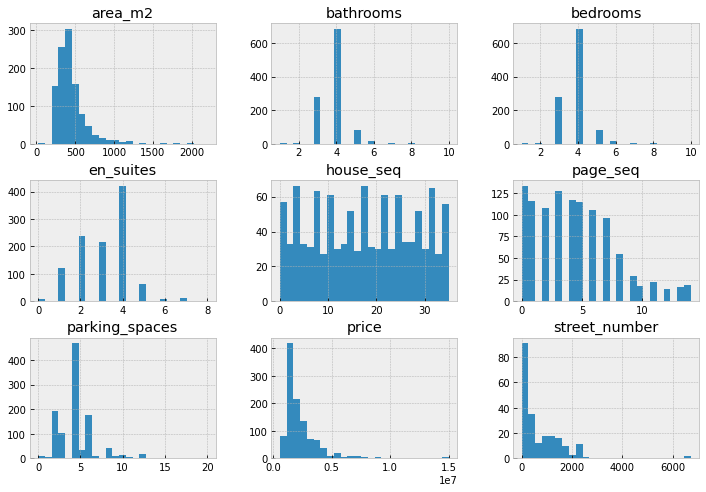

In [97]:
num_attributes.hist( bins=25 );

###  Categorical Variable

In [ ]:
#condo_name
#city
#size



## 4.2. Analise Bivariada

In [129]:
**1.** Morada dos Lagos, Pássaros e Estrelas have highest prices per square meter (m2).

**2.** Barueri-SP city prices are higher than Santana de Parnaíba-SP.

**3.** Houses with 4 bedrooms have higher prices per m2.

**4.** Houses with suites have higher prices per m2 on average.

**4.** Morada dos Lagos have more large houses.

SyntaxError: invalid syntax (<ipython-input-129-7dafb5f39c8e>, line 1)

### **H1.**Morada dos Lagos, Pássaros e Estrelas have highest prices per square meter (m2).
**** .

In [162]:
aux1 = df4.groupby('condo_name')['price_m2'].mean().sort_values().reset_index()
aux1['price_m2']= round(aux1['price_m2'],0)

px.bar(data_frame = aux1,
        x='condo_name',
        y='price_m2',
        color='condo_name',
        text='price_m2',
        title = 'Average price per m2',
        labels={'price_m2':'Price avg per m2',
                'condo_name': 'Condominium'           
               }
        )

# subfig = make_subplots(rows=1, cols=2)
# subfig.add_bar(row=1, col=1,
#                x=aux1['condo_name'],
#                 y=aux1['price_m2']
# #                color='condo_name',
# #                title = 'Average price per m2',
# #                labels={'price_m2':'Price per m2',
# #                        'condo_name': 'Condominium'           
# #                       }
#               )

# subfig.add_bar(row=1, col=2,
#                x=aux1['condo_name'],
#                y=aux1['price_m2']
# #                color='condo_name',
# #                text='price_m2',
# #                title = 'Average price per m2',
# #                labels={'price_m2':'Price per m2',
# #                        'condo_name': 'Condominium'           
# #                        }
#               )

#subfig.show()




### **H2.** Barueri-SP city prices are higher than Santana de Parnaíba-SP.
**** 

In [163]:
aux1 = df4.groupby('city')['price_m2'].mean().sort_values().reset_index()
aux1['price_m2']= round(aux1['price_m2'],0)

px.bar(data_frame = aux1,
        x='city',
        y='price_m2',
        color='city',
        text='price_m2',
        title = 'Average price per m2',
        labels={'price_m2':'Price avg per m2',
                'city': 'City'           
               }
        )


### **H3.** Houses with 4 bedrooms have higher prices per m2.
**** 

In [164]:
aux1 = df4.groupby('bedrooms')['price_m2'].mean().sort_values().reset_index()
aux1['price_m2']= round(aux1['price_m2'],0)

px.bar(data_frame = aux1,
        x='bedrooms',
        y='price_m2',
        color='bedrooms',
        text='price_m2',
        title = 'Average price per m2',
        labels={'price_m2':'Price avg per m2',
                'bedrooms': '# of Bedrooms'           
               }
        )


### **H4.** Houses with suites have higher prices per m2 on average.
**** 

In [165]:
aux1 = df4.groupby('en_suites')['price_m2'].mean().sort_values().reset_index()
aux1['price_m2']= round(aux1['price_m2'],0)

px.bar(data_frame = aux1,
        x='en_suites',
        y='price_m2',
        color='en_suites',
        text='price_m2',
        title = 'Average price per m2',
        labels={'price_m2':'Price avg per m2',
                'en_suites': '# of Suites'           
               }
        )


### **H5.** Morada dos Lagos have more large houses.
**** 

In [166]:
aux1 = df4.groupby('condo_name')['area_m2'].mean().sort_values().reset_index()
aux1['area_m2']= round(aux1['area_m2'],0)

px.bar(data_frame = aux1,
        x='condo_name',
        y='area_m2',
        color='condo_name',
        text='area_m2',
        title = 'Average price per m2',
        labels={'price_m2':'Price avg per m2',
                'condo_name': 'Condominium'           
               }
        )

In [ ]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### Categorical Attributes

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )